# Implémentez un modèle de scoring

*Notebook modélisation - simulations*

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

**Mission :**

- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

- Analyser les features qui contribuent le plus au modèle, d’une manière générale (feature importance globale) et au niveau d’un client (feature importance locale), afin, dans un soucis de transparence, de permettre à un chargé d’études de mieux comprendre le score attribué par le modèle.

- Mettre en production le modèle de scoring de prédiction à l’aide d’une API et réaliser une interface de test de cette API.

- Mettre en œuvre une approche globale MLOps de bout en bout, du tracking des expérimentations à l’analyse en production du data drift.
    + Dans le notebook d’entraînement des modèles, générer à l’aide de MLFlow un tracking d'expérimentations
    + Lancer l’interface web 'UI MLFlow" d'affichage des résultats du tracking
    + Réaliser avec MLFlow un stockage centralisé des modèles dans un “model registry”
    + Tester le serving MLFlow
    + Gérer le code avec le logiciel de version Git
    + Partager le code sur Github pour assurer une intégration continue
    + Utiliser Github Actions pour le déploiement continu et automatisé du code de l’API sur le cloud
    + Concevoir des tests unitaires avec Pytest (ou Unittest) et les exécuter de manière automatisée lors du build réalisé par Github Actions

## 1 - Préparer l'environnement d'expérimentation

### 1.1 - Imports

In [52]:
import mlflow
import mlflow.tracking
from mlflow.models import infer_signature

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, make_scorer, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # Pipeline de imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler

from contextlib import contextmanager
from collections import Counter
import time
import timeit

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("mlflow version", mlflow.__version__)
print("sklearn version", sklearn.__version__)

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 200
pd.options.display.max_columns = 130

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
mlflow version 2.20.1
sklearn version 1.6.1


### 1.2 - Lancement du serveur MLFlow

Dans le terminal de Powershell Prompt d'Anaconda, lancer cette instruction :

mlflow server --host 127.0.0.1 --port 5000 --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns

Cette commande permet de :
- Stocker les métadonnées du Model Registry dans une base de données locale SQLite.
- Stocker les artefacts (modèles, fichiers) en local.

### 1.3 - Initialisation du Tracking MLFlow de test

In [2]:
import os

# Ignorer Git
os.environ['GIT_PYTHON_REFRESH'] = 'quiet'

# Vérification si la variable d'environnement est bien définie
print(os.environ.get('GIT_PYTHON_REFRESH'))

# Définir le serveur de tracking (local ou distant) - ici local
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Démarrer une nouvelle expérimentation
mlflow.set_experiment("simulation_scoring_credit_4")

quiet


2025/02/16 13:13:45 INFO mlflow.tracking.fluent: Experiment with name 'simulation_scoring_credit_4' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/admin/mlruns/12', creation_time=1739708025002, experiment_id='12', last_update_time=1739708025002, lifecycle_stage='active', name='simulation_scoring_credit_4', tags={}>

### 1.4 - Enregistrer le modèle et ses métadonnées dans MLFlow

Créons une fonction :

In [3]:
def tracking_mlflow(tag, model, params, metrics, registered_model_name, X_train):

    # Démarrer une expérimentation dans MLflow
    with mlflow.start_run():
        try:
        
            # Log the hyperparameters
            mlflow.log_params(params)
            
            # Loguer les métriques
            for key, value in metrics.items():
                mlflow.log_metric(key, value)
                #mlflow.log_metric("accuracy", accuracy)
                #mlflow.log_metric("auc", auc)
        
            # Set a tag that we can use to remind ourselves what this run was for
            mlflow.set_tag(tag[0], tag[1])
        
            # Infer the model signature
            signature = infer_signature(X_train, model.predict(X_train))
            
            # Loguer le modèle
            model_info = mlflow.sklearn.log_model(
                sk_model=model,
                artifact_path="iris_model",
                signature=signature,
                input_example=X_train[:5],
                registered_model_name=registered_model_name,
            )
    
            for key, value in metrics.items():
                print(key, ":" , value)

        except Exception as e:
            print(f"❌ Erreur dans MLflow : {e}")

        finally:
            mlflow.end_run()  # Assure que la run est bien fermée
    
    print(f"Modèle enregistré en version {model_info.mlflow_version}")
    
    return model_info

### 1.5 - Lancement de l'UI

Pour  la visualisation et la comparaison des expérimentations, ainsi que le stockage de manière centralisée des modèles.

Cliquer sur ce lien : http://127.0.0.1:5000/

### 1.6 - Charger les données issues du feature engineering

In [4]:
df = pd.read_csv('C:/Users/admin/Documents/Projets/Projet_7/data_projet/cleaned/data.csv')

print('Training data shape: ', df.shape)
df.head()

Training data shape:  (307507, 395)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,...,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_nan
0,100002.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.00,0.0690,0.0833,0.0369,0.0190,0.0000,0.0252,0.0383,0.9722,0.0000,0.0690,0.0833,0.0377,0.0198,0.0000,0.0250,0.0369,0.9722,0.00,0.0690,0.0833,0.0375,0.0193,0.0000,0.0149,2.0,2.0,2.0,2.0,-1134.0,0.0,...,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,100003.0,0.0,0.0,270000.0,1293502.5,35698

In [27]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [28]:
# Missing values statistics
missing_values = missing_values_table(df)
missing_values.head(130)

Your selected dataframe has 395 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Bien. Aucune valeur manquante.

## 2 - Créer un score métier pour l'entraînement des modèles

### 2.1 - Créer le score métier

In [39]:
debug_info = []  # Stocker les logs

def calculate_errors_cost(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    warnings.warn(f"Confusion Matrix:\n{cm}")
    debug_info.append(f"Confusion Matrix:\n{cm}")  # Sauvegarde
    tn, fp, fn, tp = cm.ravel()
    return 10 * fn + fp

Test de la fonction : 

In [41]:
y_test_sample = [0, 1, 1, 0, 1, 0, 0, 1, 1, 0]
y_pred_sample = [0, 0, 1, 0, 1, 0, 1, 1, 1, 0]

print("Résultat de calculate_errors_cost:", calculate_errors_cost(y_test_sample, y_pred_sample))

Résultat de calculate_errors_cost: 11


### 2.2 - Créer une classe pour ajouter le seuil dans le GridSearchCV

Le seuil optimal est la valeur à partir de laquelle on décide si un client doit obtenir ou non un crédit, basé sur la probabilité prédite par le modèle. Le but est de trouver un seuil qui minimise le coût métier, c'est-à-dire le coût total des erreurs de prédiction en tenant compte des faux positifs (FP) et des faux négatifs (FN), où les faux négatifs sont 10 fois plus coûteux.

Le seuil optimal est celui qui donne le coût total le plus bas.

Le seuil sera ajouté dans le param_grid en entrée du GridSearchCV. On ajustera ainsi le seuil de décision en même temps que les autres hyperparamètres.

In [55]:
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model, threshold=0.5):
        self.base_model = base_model
        self.threshold = threshold

    def fit(self, X, y):
        self.base_model.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.base_model.predict_proba(X)

    def predict(self, X):
        # Applique le seuil sur les probabilités
        y_scores = self.predict_proba(X)[:, 1]
        return (y_scores >= self.threshold).astype(int)

## 4 - Simuler et comparer plusieurs modèles avec undersampling

Pour corriger le déséquilibre entre le nombre de bons et de moins bons clients, 3 solutions peuvent être utilisées :

- SMOTE : qui permet de génèrer des exemples synthétiques pour la classe minoritaire, en créant de nouvelles instances en interpolant entre les exemples existants de la classe minoritaire.

  -- j'ai commencé avec cette méthode, mais les temps de traitement étaient trop long, et faisait planter mon PC à cause des 300 000 lignes qu'il générère pour le réquilibrage. 

- Ou par ajustement des poids des classes par paramétrage des modèles de type "class_weight"
  
    -- Logistic Regression avec class_weight="balanced"
  
  -- Random Forest avec class_weight="balanced"
  
  -- Decision Tree avec class_weight="balanced"
  
  -- XGBoost avec scale_pos_weight
  
  -- LightGBM avec is_unbalance=True ou scale_pos_weight

- Ou par Undersampling (sous-échantillonage) : réduire la taille de la classe majoritaire pour équilibrer les proportions. L'avantage c'est qu'elle réduit la taille du dataset, ce qui permet un gain de rapidité pour des premières simulation. Je vais donc commencer les simulations avec cette méthodes, pour faire une 1ere sélection des modèles, et ensuite je travaillerais avec SMOTE (oversampling) pour l'affinage.

### 4.1 - Préparer le dataset avec undersampling

Distribution après sous-échantillonnage : Counter({0.0: 24825, 1.0: 24825})
taille X_train :  (39720, 394)
taille y_train :  (39720,)
taille X_test :  (9930, 394)
taille y_test :  (9930,)


<Axes: ylabel='Frequency'>

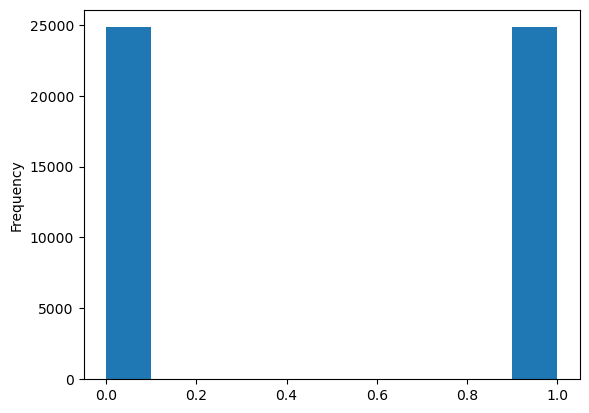

In [10]:
# Définition des features et de la target
X = df.drop(columns=["TARGET"])  # Features
y = df["TARGET"]  # Variable cible

# sous-échantillonage
X_resampled, y_resampled = RandomUnderSampler().fit_resample(X, y)
print(f"Distribution après sous-échantillonnage : {Counter(y_resampled)}")

# Centrage et réduction des données
X_scale = StandardScaler().fit_transform(X_resampled)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scale, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print("taille X_train : ", X_train.shape)
print("taille y_train : ", y_train.shape)
print("taille X_test : ", X_test.shape)
print("taille y_test : ", y_test.shape)

y_resampled.plot.hist()

In [43]:
# Scorers personnalisés
metrics = {
    "business_score": make_scorer(calculate_errors_cost, greater_is_better=False),
    "scorer_threshold": make_scorer(business_threshold_score, needs_proba=True),
    "accuracy": make_scorer(accuracy_score),  # Accuracy classique,
    "auc": make_scorer(roc_auc_score, needs_proba=True),
    "f1_macro": make_scorer(f1_score, average="macro"),  # F1-score macro
}

### 4.2 - Simuler avec DumyClassifier (Baseline)

In [53]:
# Scorers personnalisés
metrics_dummy = {
    "accuracy": make_scorer(accuracy_score),  # Accuracy classique,
    "f1_macro": make_scorer(f1_score, average="macro"),  # F1-score macro
}

In [55]:
# Définition des paramètres à tester
param_grid = {
    'strategy': ['most_frequent']
}

In [57]:
print("📂 Lancement du traitement DummyClassifier...")
start_time = timeit.default_timer()

# Initialisation du modèle
dummy_clf = DummyClassifier()

# GridSearchCV avec plusieurs scores
grid_search = GridSearchCV(dummy_clf, param_grid, scoring=metrics_dummy, refit="accuracy", cv=5, n_jobs=1, verbose=1)

# Exécution de la recherche
grid_search.fit(X_train, y_train)

elapsed = round(timeit.default_timer() - start_time, 3)
print("📂 Durée depuis le début : ", elapsed, " - Fin entraînement DummyClassifier...")

# Meilleur modèle trouvé
best_dummy = grid_search.best_estimator_
best_params = grid_search.best_params_

# Extraction des scores
results = grid_search.cv_results_
best_index = grid_search.best_index_

# Préparation des métriques à logger
metrics_log = {
    "accuracy": grid_search.best_score_,
    "mean_fit_time": round(results["mean_fit_time"][best_index], 3),
}

# Ajout des autres scores
for metric in metrics_dummy.keys():
    metrics_log[f"mean_{metric}"] = results[f"mean_test_{metric}"][best_index]

# Définition des tags MLflow
tag = ("model_type", "Baseline - DummyClassifier")

# Nom du modèle à enregistrer dans MLflow
registered_model_name = "DummyClassifier_GridSearch"

elapsed = round(timeit.default_timer() - start_time, 3)
print("📂 Durée depuis le début : ", elapsed, " - Début tracking MLFlow DummyClassifier...")

# Appel de la fonction tracking_mlflow
tracking_mlflow(tag, best_dummy, best_params, metrics_log, registered_model_name, X_train)

elapsed = round(timeit.default_timer() - start_time, 3)
print("📂 Durée depuis le début : ", elapsed, " - Fin tracking MLFlow DummyClassifier...")

print(f"✅ Fin traitement DummyClassifier")

"""
# Affichage des résultats
print("Meilleure stratégie :", grid_search.best_params_["strategy"])
print("Meilleur business score :", grid_search.best_score_)

# Affichage des autres scores
for metric in metrics.keys():
    mean_score = results[f"mean_test_{metric}"][grid_search.best_index_]
    print(f"{metric} (moyenne) :", mean_score)

mean_fit_time = results["mean_fit_time"][grid_search.best_index_]
print(f"temps moyen d'entraînement :", round(mean_fit_time,3))
"""

📂 Lancement du traitement DummyClassifier...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
📂 Durée depuis le début :  0.642  - Fin entraînement DummyClassifier...
📂 Durée depuis le début :  0.643  - Début tracking MLFlow DummyClassifier...


Registered model 'DummyClassifier_GridSearch' already exists. Creating a new version of this model...
2025/02/15 19:17:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DummyClassifier_GridSearch, version 2
Created version '2' of model 'DummyClassifier_GridSearch'.


accuracy : 0.5
mean_fit_time : 0.075
mean_accuracy : 0.5
mean_f1_macro : 0.3333333333333333
🏃 View run grandiose-snipe-950 at: http://127.0.0.1:5000/#/experiments/11/runs/3225b54678e14f1c82903004181a4e87
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/11
Modèle enregistré en version 2.20.1
📂 Durée depuis le début :  28.531  - Fin tracking MLFlow DummyClassifier...
✅ Fin traitement DummyClassifier


'\n# Affichage des résultats\nprint("Meilleure stratégie :", grid_search.best_params_["strategy"])\nprint("Meilleur business score :", grid_search.best_score_)\n\n# Affichage des autres scores\nfor metric in metrics.keys():\n    mean_score = results[f"mean_test_{metric}"][grid_search.best_index_]\n    print(f"{metric} (moyenne) :", mean_score)\n\nmean_fit_time = results["mean_fit_time"][grid_search.best_index_]\nprint(f"temps moyen d\'entraînement :", round(mean_fit_time,3))\n'

### 4.3 - Simuler avec LogisticRegression

In [ ]:
print("📂 Lancement du traitement LogisticRegression...")
start_time = timeit.default_timer()

# Initialisation du modèle
base_model = LogisticRegression(solver="liblinear", random_state=42)  # Utilisation d'un solver adapté

# Créer un wrapper pour intégrer le seuil
custom_model = ThresholdClassifier(base_model=base_model)

param_grid = {
    "base_model__C": [0.01, 0.1, 1],  # Régularisation
    "threshold": [0.4, 0.5, 0.6, 0.7]  # Différents seuils à tester
}

# GridSearchCV avec plusieurs scores
grid_search = GridSearchCV(custom_model, param_grid, scoring=metrics, refit="business_score", cv=5, n_jobs=-1, verbose=1)

# Exécution de la recherche
grid_search.fit(X_train, y_train)

elapsed = round(timeit.default_timer() - start_time, 3)
print("📂 Durée depuis le début : ", elapsed, " - Fin entraînement LogisticRegression...")

# Meilleur modèle trouvé
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Extraction des scores
results = grid_search.cv_results_
best_index = grid_search.best_index_

# Préparation des métriques à logger
metrics_log = {
    "best_business_score": grid_search.best_score_,
    "mean_fit_time": round(results["mean_fit_time"][best_index], 3),
}

# Ajout des autres scores
for metric in metrics.keys():
    metrics_log[f"mean_{metric}"] = results[f"mean_test_{metric}"][best_index]

# Définition des tags MLflow
tag = ("model_type", "LogisticRegression")

# Nom du modèle à enregistrer dans MLflow
registered_model_name = "LogisticRegression_GridSearch"

elapsed = round(timeit.default_timer() - start_time, 3)
print("📂 Durée depuis le début : ", elapsed, " - Début tracking MLFlow LogisticRegression...")

# Appel de la fonction tracking_mlflow
tracking_mlflow(tag, best_model, best_params, metrics_log, registered_model_name, X_train)

elapsed = round(timeit.default_timer() - start_time, 3)
print("📂 Durée depuis le début : ", elapsed, " - Fin tracking MLFlow LogisticRegression...")

print(f"✅ Fin traitement LogisticRegression")

📂 Lancement du traitement LogisticRegression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [46]:
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score business_score :", grid_search.best_score_)

# Vérification des scores pour chaque fold
print("Résultats du cross-validation :")
for metric in metrics.keys():
    print(f"{metric}: {grid_search.cv_results_.get(f'mean_test_{metric}', 'Non disponible')}")

Meilleurs paramètres : {'C': 0.1, 'penalty': 'l2'}
Meilleur score business_score : -13216.0
Résultats du cross-validation :
business_score: [-13550.6 -13314.  -13341.2 -13216. ]
scorer_threshold: [nan nan nan nan]
accuracy: [0.69431017 0.69599698 0.69619839 0.69723061]
auc: [nan nan nan nan]
f1_macro: [0.69429715 0.69599151 0.69619286 0.69722596]


In [47]:
debug_info

['Confusion Matrix:\n[[4 1]\n [1 4]]']

In [ ]:
DummyClassifier, Regression Logistique, Random Forest, Decision Tree, XGBoost, Lightgbm

Courbe Roc, AUC, f1-score, precision, recall, time

matrice de confusion